Response for Feature_1: model='mistral' created_at='2025-03-03T13:57:44.043228Z' done=True done_reason='stop' total_duration=14898016583 load_duration=13276375 prompt_eval_count=98 prompt_eval_duration=2246000000 eval_count=605 eval_duration=12636000000 message=Message(role='assistant', content=" Ich habe 100 zufällige numerische Werte zwischen -10 und 10 erzeugt für das Feature 'Feature_1'. Hier ist die Liste:\n\n```json\n[3.12, -5.67, 7.89, -0.23, 2.45, -8.90, 6.12, -3.56, 1.78, 9.45,\n-2.31, 5.67, -4.89, 1.23, 7.90, -0.12, 3.56, -6.78, 2.34, 8.90,\n-1.23, 5.67, -7.89, 0.22, 2.46, -9.00, 6.13, -3.57, 1.79, 9.46,\n-2.32, 5.68, -4.90, 1.24, 7.91, -0.13, 3.57, -6.79, 2.35, 8.91,\n-1.24, 5.69, -7.90, 0.24, 2.47, -9.01, 6.14, -3.58, 1.80, 9.47,\n-2.33, 5.70, -4.91, 1.25, 7.92, -0.14, 3.58, -6.80, 2.36, 8.92,\n-1.25, 5.71, -7.93, 0.26, 2.48, -9.02, 6.15, -3.59, 1.81, 9.48,\n-2.34, 5.72, -4.92, 1.26, 7.94, -0.15, 3.59, -6.81, 2.37, 8.93,\n-1.26, 5.73, -7.95, 0.27, 2.49, -9.03, 6.16, -3.60, 

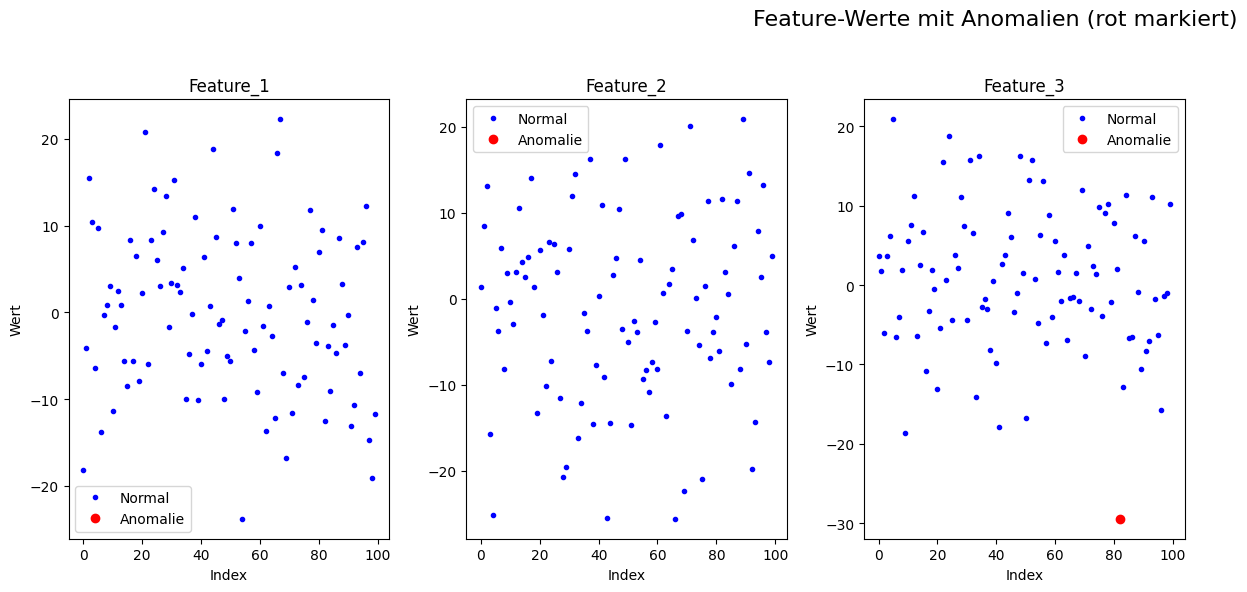

[{"Feature_1":-18.1623658822,"Feature_2":1.363614137,"Feature_3":3.59975276},{"Feature_1":-4.1051242368,"Feature_2":8.5078849148,"Feature_3":1.7488839635},{"Feature_1":15.5093757668,"Feature_2":13.0724692128,"Feature_3":-6.0592651868},{"Feature_1":10.4288708414,"Feature_2":-15.7802274671,"Feature_3":3.6930988085},{"Feature_1":-6.4163494637,"Feature_2":-25.1583060601,"Feature_3":6.2360207809},{"Feature_1":9.7216903814,"Feature_2":-1.0704231296,"Feature_3":20.9048027065},{"Feature_1":-13.7369669331,"Feature_2":-3.7244090871,"Feature_3":-6.5103450965},{"Feature_1":-0.3225801834,"Feature_2":5.8684685896,"Feature_3":-3.9999807321},{"Feature_1":0.84152732,"Feature_2":-8.2348293227,"Feature_3":1.9294495518},{"Feature_1":3.0830593274,"Feature_2":2.9994153407,"Feature_3":-18.6318433176},{"Feature_1":-11.3862412161,"Feature_2":-0.3692412386,"Feature_3":5.6072206584},{"Feature_1":-1.6956576409,"Feature_2":-2.9101822028,"Feature_3":7.5623442938},{"Feature_1":2.4363967447,"Feature_2":3.0583407579,"

In [2]:
import pandas as pd
import json
import ollama
import numpy as np
import matplotlib.pyplot as plt

# ======================
# 1. Datenerzeugung mit Ollama
# ======================
features = ['Feature_1', 'Feature_2', 'Feature_3']
data = {feature: generate_data_with_llm(feature) for feature in features}
df = pd.DataFrame(data)

def generate_data_with_llm(feature_name, num_samples=100):
    prompt = f"""
    Erstelle {num_samples} zufällige numerische Werte für das Feature '{feature_name}'.
    Die Werte sollen realistisch für wissenschaftliche Daten sein und ein breites Spektrum abdecken.
    Gib die Zahlen ausschließlich als JSON-Liste zurück, z. B. [12.3, -4.5, 6.7, ...]
    """
    
    response = ollama.chat(model='mistral', messages=[{"role": "user", "content": prompt}])
    
    # Print the response for debugging
    print(f"Response for {feature_name}: {response}")
    
    try:
        # Check if the response contains the expected keys
        if 'message' not in response or 'content' not in response['message']:
            raise ValueError("Response does not contain 'message' or 'content' keys")
        
        # Extract the JSON content from the response
        content = response['message']['content']
        start_idx = content.find('[')
        end_idx = content.rfind(']') + 1
        json_str = content[start_idx:end_idx]
        
        # Parse the JSON content
        data = json.loads(json_str)
        
        # Validate the parsed data
        if isinstance(data, list) and len(data) == num_samples:
            return data
        else:
            print(f"Warnung: Ungültige Daten für {feature_name}, Standardwerte werden genutzt.")
            return list(np.random.normal(0, 10, num_samples))  # Fallback
    except json.JSONDecodeError as e:
        print(f"JSONDecodeError beim Parsen von LLM-Antwort für {feature_name}: {e}")
        return list(np.random.normal(0, 10, num_samples))  # Fallback
    except Exception as e:
        print(f"Allgemeiner Fehler beim Parsen von LLM-Antwort für {feature_name}: {e}")
        return list(np.random.normal(0, 10, num_samples))  # Fallback

# ======================
# 2. Anomalien setzen
# ======================

anomalies = {
    'Feature_1': [np.nan, -500],
    'Feature_2': [10, 50],
    'Feature_3': [-1000, 500]
}

for feature, value in anomalies.items():
    df.loc[df[feature].isna(), feature] = np.nan
    df.loc[df[feature] == value[1], feature] = value[1]

# ======================
# 3. Anomalieerkennung
# ======================
means = df.mean()
stds = df.std()

def is_anomaly(series, mean, std, threshold=3):
    return (series.isna()) | (series < mean - threshold*std) | (series > mean + threshold*std)

anomaly_indices = {col: is_anomaly(df[col], means[col], stds[col]) for col in df.columns}

# ======================
# 4. Datenvisualisierung
# ======================
num_features = len(df.columns)
cols = 5
rows = (num_features + cols - 1) // cols

plt.figure(figsize=(20, 6))
plt.suptitle("Feature-Werte mit Anomalien (rot markiert)", fontsize=16)

for i, feature in enumerate(df.columns, start=1):
    plt.subplot(rows, cols, i)
    plt.plot(df[feature].values, 'b.', label='Normal')
    anomaly_idx = df.index[anomaly_indices[feature]]
    plt.plot(anomaly_idx, df.loc[anomaly_idx, feature], 'ro', label='Anomalie')
    plt.title(feature)
    plt.xlabel('Index')
    plt.ylabel('Wert')
    plt.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ======================
# 5. JSON-Ausgabe
# ======================
json_data = df.to_json(orient='records')
print(json_data)

# JSON für Anomalien
anomaly_dict = {col: df.index[anomaly_indices[col]].tolist() for col in df.columns}
json_anomalies = json.dumps(anomaly_dict, indent=4)
print(json_anomalies)